### Import libraries

In [0]:
import pandas as pd # for data wrangling and analysis
import numpy as np # for mathematical calculation
import matplotlib.pyplot as plt # for plotting graph
import warnings # to ignore the warnings
%matplotlib inline

from datetime import datetime # for datetime
from pandas import Series # to work on series
warnings.filterwarnings('ignore')

import seaborn as sns # for data vizualisation

### Read the data

In [0]:
train_data = pd.read_csv('/content/dataset/JetRail_Train_SU63ISt.csv')
test_data = pd.read_csv('/content/dataset/JetRain_Test_0qrQsBZ.csv')

In [0]:
# Let'make a copy of the original dataset
train_data_original = train_data.copy()
test_data_original = test_data.copy()

### Data vizualisation

In [111]:
# let's see the data structure
train_data.columns, test_data.columns

(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

* ID is the unique number given to each observation point.
* Datetime is the time of each observation.
* Count is the passenger count corresponding to each Datetime.

In [112]:
# Data type for each feature
train_data.dtypes, test_data.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object, ID           int64
 Datetime    object
 dtype: object)

ID and Count are in integer format while the Datetime is in object format.

In [113]:
# let's see the number of rows and columns in our data
train_data.shape, test_data.shape

((18288, 3), (5112, 2))

In [114]:
# let's see the first five rows in the train data
train_data.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [115]:
# let's see the first five rows in the test data
test_data.head()

,ID,Datetime
0,18288,26-09-2014 00:00
1,18289,26-09-2014 01:00
2,18290,26-09-2014 02:00
3,18291,26-09-2014 03:00
4,18292,26-09-2014 04:00


In [116]:
# let'see if we have null data in the train set
train_data.isnull().any()

ID          False
Datetime    False
Count       False
dtype: bool

In [117]:
# let'see if we have null data in the test set
test_data.isnull().any()

ID          False
Datetime    False
dtype: bool

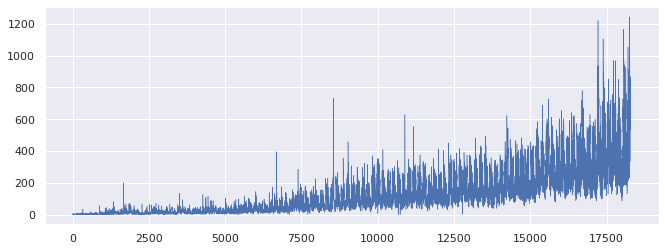

In [118]:
#Let's try to plot our train data
sns.set(rc={'figure.figsize':(11, 4)})
train_data['Count'].plot(linewidth=0.5);

We can not undestand what we have plotted, We have to extract the time and date from the Datetime.  the data type of Datetime is object. We have to change the data type to datetime format so we will be able extract features from it.

### Feature Extraction

In [0]:
# Change the format of the column Datetime to datetime
train_data['Datetime'] = pd.to_datetime(train_data.Datetime, format='%d-%m-%Y %H:%M')
test_data['Datetime'] = pd.to_datetime(test_data.Datetime, format='%d-%m-%Y %H:%M') 
# we can do the same on our original data
train_data_original['Datetime'] = pd.to_datetime(train_data_original.Datetime, 
                                                 format='%d-%m-%Y %H:%M')
test_data_original['Datetime'] = pd.to_datetime(test_data_original.Datetime, 
                                                format='%d-%m-%Y %H:%M') 

In [120]:
train_data.dtypes, test_data.dtypes

(ID                   int64
 Datetime    datetime64[ns]
 Count                int64
 dtype: object, ID                   int64
 Datetime    datetime64[ns]
 dtype: object)

In [0]:
# Now we have the column Datetime in datetime format
# Let's extract the yeay, month and day
for i in (train_data, test_data, train_data_original, test_data_original):
  i['year']=i.Datetime.dt.year
  i['month']=i.Datetime.dt.month
  i['day']=i.Datetime.dt.day
  i['Hour']=i.Datetime.dt.hour

We will also need a traffic model on weekdays and weekends. So let's do a weekend variable to visualize the impact of the weekend on traffic.

In [0]:
# extract the day of week from Datetime
train_data['day of week']=train_data['Datetime'].dt.dayofweek 
temp = train_data['Datetime']

In [0]:
# assign 1 if the day of week is a weekend, 
# 0 if the day of week in not a weekend.
#  and 6 represents that the days are weekend.
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0

In [0]:
temp2 = train_data['Datetime'].apply(applyer) 
train_data['weekend']=temp2

In [125]:
#Let's see our train_data
train_data.head()

,ID,Datetime,Count,year,month,day,Hour,day of week,weekend
0,0,2012-08-25 00:00:00,8,2012,8,25,0,5,1
1,1,2012-08-25 01:00:00,2,2012,8,25,1,5,1
2,2,2012-08-25 02:00:00,6,2012,8,25,2,5,1
3,3,2012-08-25 03:00:00,2,2012,8,25,3,5,1
4,4,2012-08-25 04:00:00,2,2012,8,25,4,5,1


In [126]:
train_data.tail()

,ID,Datetime,Count,year,month,day,Hour,day of week,weekend
18283,18283,2014-09-25 19:00:00,868,2014,9,25,19,3,0
18284,18284,2014-09-25 20:00:00,732,2014,9,25,20,3,0
18285,18285,2014-09-25 21:00:00,702,2014,9,25,21,3,0
18286,18286,2014-09-25 22:00:00,580,2014,9,25,22,3,0
18287,18287,2014-09-25 23:00:00,534,2014,9,25,23,3,0


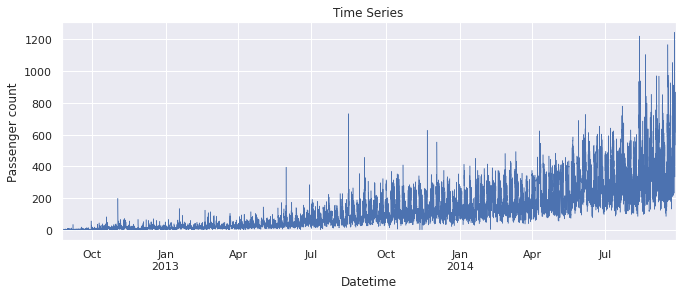

In [127]:
sns.set(rc={'figure.figsize':(11, 4)})
# to get the period on the x-axis
train_data.index = train_data['Datetime'] 
# drop ID variable to get only Datetime on x-axis
df = train_data.drop('ID', 1)
ts = df['Count']
plt.title('Time Series') 
plt.xlabel("Time(year-month)") 
plt.ylabel("Passenger count")
df['Count'].plot(linewidth=0.5);
# plt.plot(ts, label='Passenger Count') 
# plt.legend(loc='best')

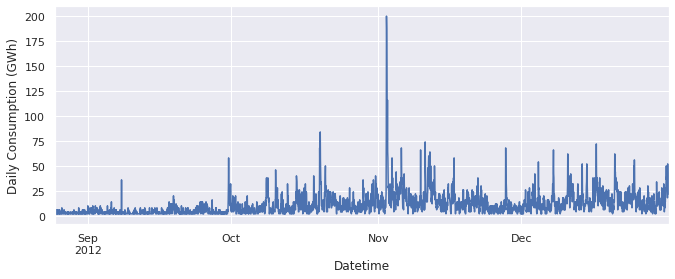

In [128]:
ax = df.loc['2012', 'Count'].plot()
ax.set_ylabel('Daily Consumption (GWh)');

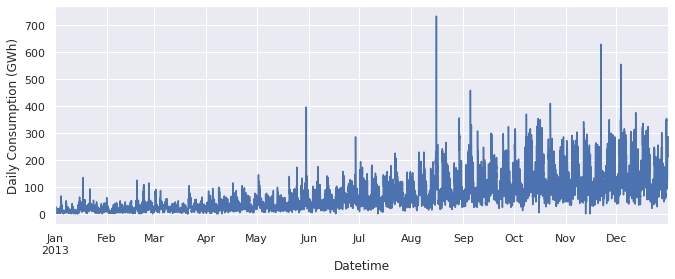

In [129]:
ax = df.loc['2013', 'Count'].plot()
ax.set_ylabel('Daily Consumption (GWh)');

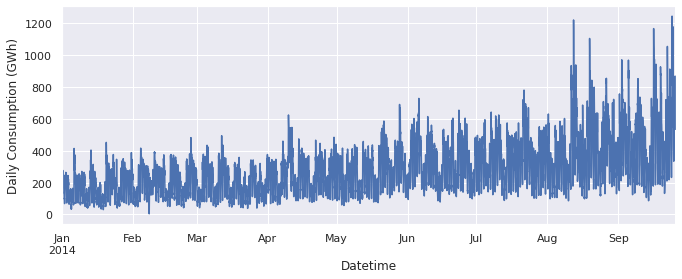

In [130]:
ax = df.loc['2014', 'Count'].plot()
ax.set_ylabel('Daily Consumption (GWh)');

### Exploratory Analysis

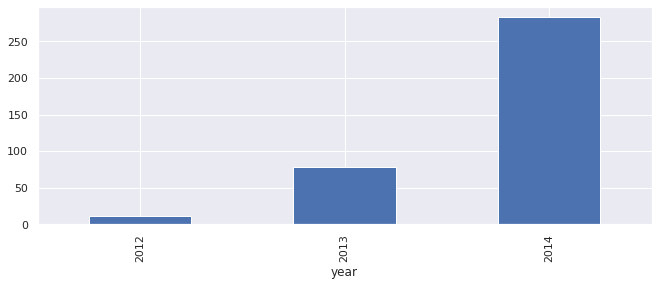

In [131]:
# let’s look at yearly passenger count.
train_data.groupby('year')['Count'].mean().plot.bar()

 There is an exponential growth in the traffic with respect to year

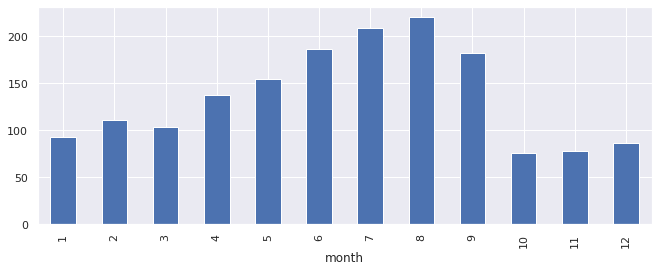

In [132]:
# let’s see the relation between count and month.
train_data.groupby('month')['Count'].mean().plot.bar()

we see a decrease in the mean of passenger count in last three months

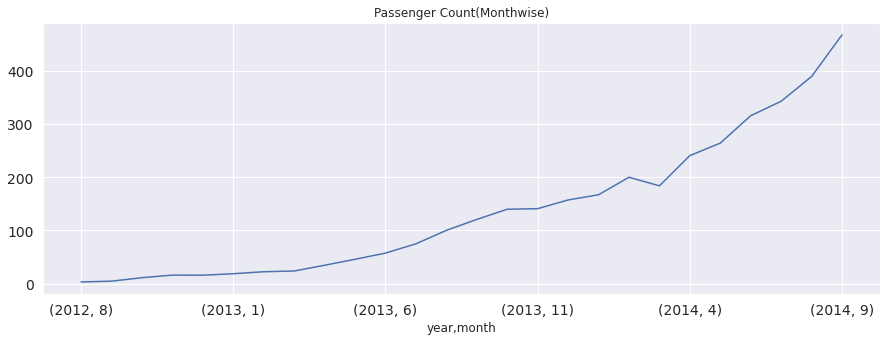

In [133]:
# Let’s look at the monthly mean of each year separately.
temp=train_data.groupby(['year', 'month'])['Count'].mean() 
temp.plot(figsize=(15,5), title= 'Passenger Count(Monthwise)', fontsize=14)

The months 10, 11 and 12 are not present for the year 2014 and the mean value for these months in year 2012 is very less.

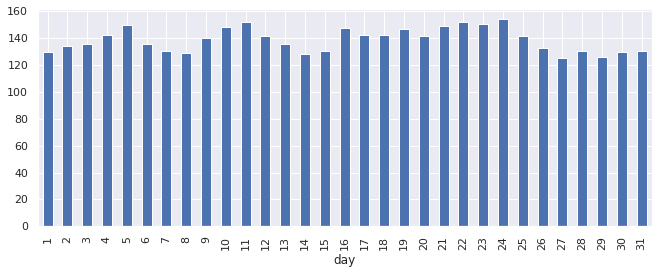

In [134]:
# Let’s look at the daily mean of passenger count.
train_data.groupby('day')['Count'].mean().plot.bar()

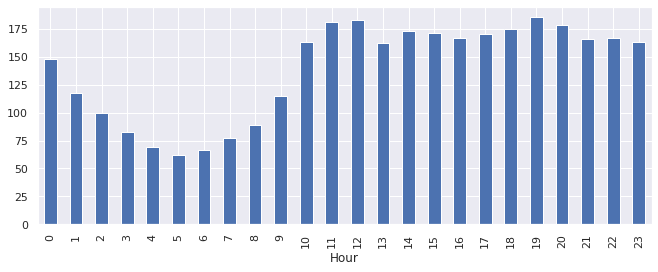

In [135]:
# So let’s see the mean of hourly passenger count.
train_data.groupby('Hour')['Count'].mean().plot.bar()

There is a lot of noise in the hourly time series, we will aggregate the hourly time series to daily, weekly, and monthly time series to reduce the noise and make it more stable and hence would be easier for a model to learn.

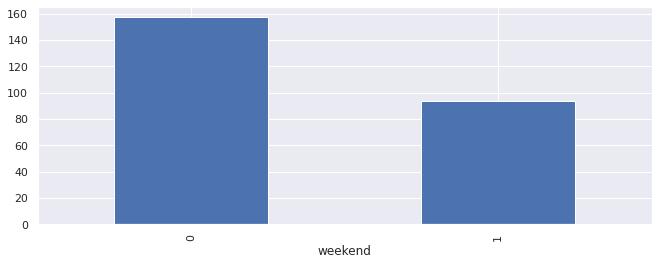

In [136]:
# So let’s see the mean of weeksday passenger count.
train_data.groupby('weekend')['Count'].mean().plot.bar()

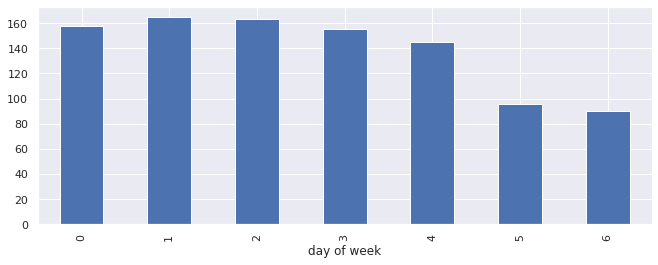

In [137]:
# let's see the day wise passenger count.
train_data.groupby('day of week')['Count'].mean().plot.bar()

In [0]:
train_data.Timestamp = pd.to_datetime(train_data.Datetime,format='%d-%m-%Y %H:%M') 
train_data.index = train_data.Timestamp 
# Hourly time series 
hourly = train_data.resample('H').mean() 
# Converting to daily mean 
daily = train_data.resample('D').mean() 
# Converting to weekly mean 
weekly = train_data.resample('W').mean() 
# Converting to monthly mean 
monthly = train_data.resample('M').mean()

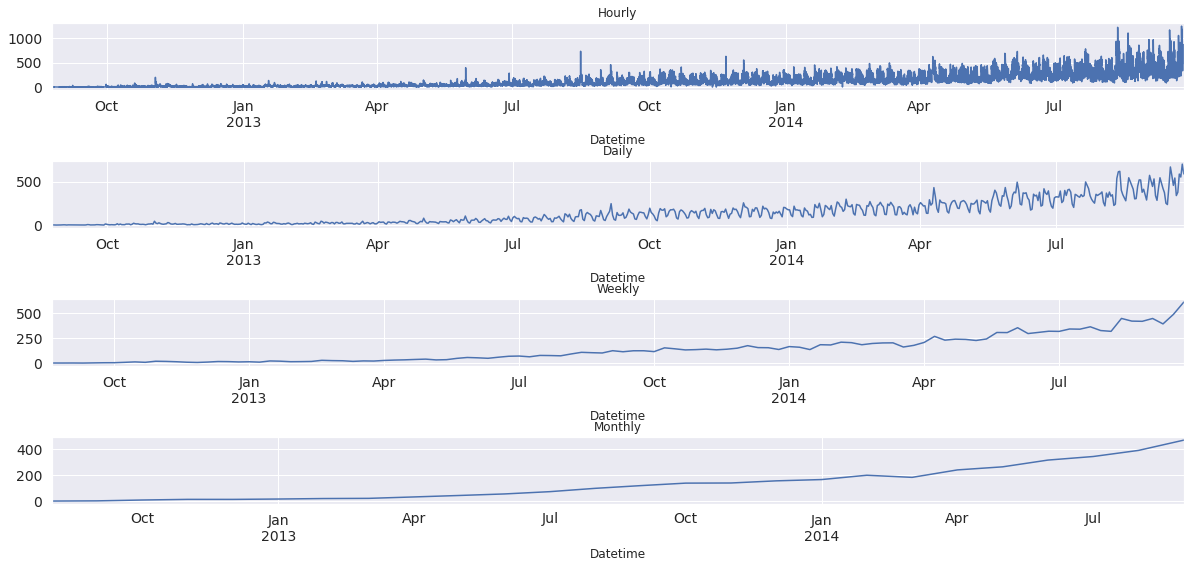

In [139]:
# now we can plot the hourly, daily, weekly and monthly time series.
fig, axs = plt.subplots(4,1) 
fig.tight_layout(pad=1.0)
hourly.Count.plot(figsize=(17,8), title= 'Hourly', fontsize=14, ax=axs[0]) 
daily.Count.plot(figsize=(17,8), title= 'Daily', fontsize=14, ax=axs[1]) 
weekly.Count.plot(figsize=(17,8), title= 'Weekly', fontsize=14, ax=axs[2]) 
monthly.Count.plot(figsize=(17,8), title= 'Monthly', fontsize=14, ax=axs[3]) 

In [0]:
test_data.Timestamp = pd.to_datetime(test_data.Datetime,format='%d-%m-%Y %H:%M') 
test_data.index = test_data.Timestamp  

# Converting to daily mean 
test_data = test_data.resample('D').mean() 

train_data.Timestamp = pd.to_datetime(train_data.Datetime,format='%d-%m-%Y %H:%M') 
train_data.index = train_data.Timestamp 
# Converting to daily mean 
train_data = train_data.resample('D').mean()

### Split the data into Train and test data

* The dataset should have the true values of the dependent variable against which the predictions can be checked. Therefore, test dataset cannot be used for the purpose.

* The model should not be trained on the validation dataset. Hence, we cannot train the model on the train dataset and validate on it as well.

The total duration is 25 months. We will take 3 months for the validation data
If we would have done it randomly it may work well for the train dataset but will not work effectively on validation dataset.

In [0]:
trainData=train_data.loc['2012-08-25':'2014-06-24'] 
validData=train_data.loc['2014-06-25':'2014-09-25']

In [147]:
trainData.shape, validData.shape

((669, 2), (93, 2))

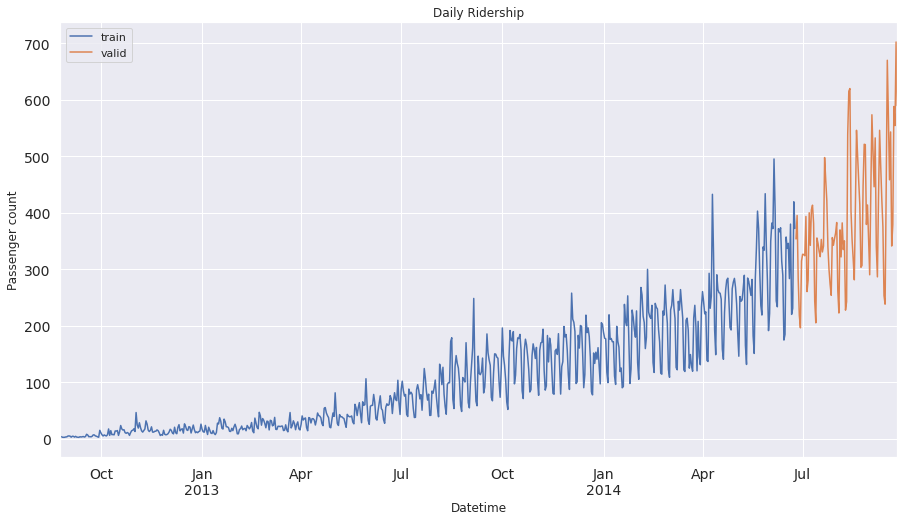

In [148]:
# Let's see how the train and validation part has been divided.
trainData.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='train') 
validData.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='valid') 
plt.xlabel("Datetime") 
plt.ylabel("Passenger count") 
plt.legend(loc='best') 
plt.show()